In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [101]:
# read the csv with M2 money supply and housing price index

M2 = pd.read_csv('/Users/floyd/Projects1/PyplotAndStuff/M2NS.csv', 
                 delimiter = ',', 
                 parse_dates = ["DATE"], 
                 index_col = 'DATE')

housing = pd.read_csv('/Users/floyd/Projects1/PyplotAndStuff/CSUSHPINSA.csv',
                           delimiter = ',',
                           parse_dates = ["DATE"],
                           index_col = 'DATE')

# Drops the dates that are not in common

M2 = M2.loc['1987-01-01':'2021-03-01']
M2 = M2/1000


In [102]:
# This combines my two dataframes into one dataframe, and it renames the columns.

df = pd.concat([M2, housing], axis=1)
columns = ["M2 Money Supply", "Housing Price Index (USA)"]
df.columns = columns


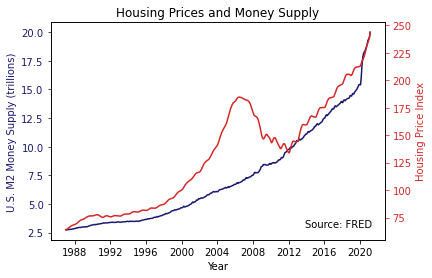

In [103]:
## Graph my two series (will make this into a usable function later, hopefully?)

fig, ax = plt.subplots()
ax.plot(df.index, df["M2 Money Supply"], color='midnightblue')
ax.set_xlabel("Year")
ax.set_ylabel("U.S. M2 Money Supply (trillions)", color='midnightblue')
ax.set_title("Housing Prices and Money Supply")
ax.tick_params('y', colors='midnightblue')
ax.text(16000,3, "Source: FRED", fontsize=10, color="black")

ax2 = ax.twinx()
ax2.plot(df.index, df["Housing Price Index (USA)"], color='tab:red')
ax2.set_ylabel("Housing Price Index", color='tab:red')
ax2.tick_params('y', colors='tab:red')
plt.savefig('/Users/floyd/Projects1/PyplotAndStuff/housing_and_M2.png')  
plt.show()

In [104]:
## Obviously these are positively correlated, which is expected since asset prices tend to at a minimum
## keep up with inflation (or increase in monetary base). Some notable aspects of the series:
## Housing shows some seasonality from the "bumpiness," there is a rather large break in the series 
## from the bubble that led to the financial crisis, and at the present housing prices have not yet
## diverged from the increase in money supply (no indication of bubble?)

In [105]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
np.random.seed(42)

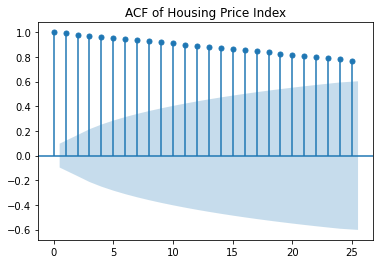

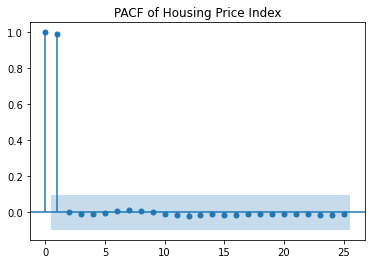

In [106]:
## Now for some time-series analysis

sm.graphics.tsa.plot_acf(df['Housing Price Index (USA)'].values.squeeze(), lags=25, title='ACF of Housing Price Index')
sm.graphics.tsa.plot_pacf(df['Housing Price Index (USA)'].values.squeeze(), lags=25, title='PACF of Housing Price Index')
plt.show()


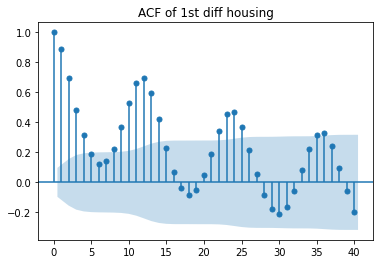

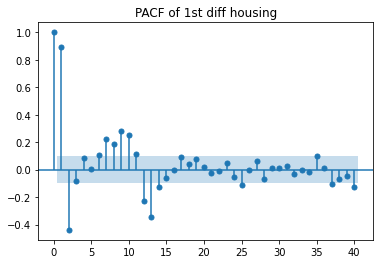

In [107]:
## There are two significant lags on the PACF, and the ACF slowly decays linearly, indicating that this data is 
## non-stationary.Given the two significant lags on the PACF, it's safe to say this is likely going to be an
## AR(2) data generating process, so we should attempt to model it as such. First I will try the first difference.


D_housing = df['Housing Price Index (USA)'].diff()
sm.graphics.tsa.plot_acf(D_housing.values.squeeze(), lags=40, title='ACF of 1st diff housing', missing= "conservative")
sm.graphics.tsa.plot_pacf(D_housing[1:].values.squeeze(), lags=40, title='PACF of 1st diff housing')
plt.show()

In [108]:
## The 1st difference looks more or less stationary, but there is an obvious seasonality to the data given by
## the periodic ups and downs in the ACF. To model this I'll make monthly seasonal dummies. 
## Brendan (macroeconomist professor) said 1st difference is "more than enough"

month = pd.DataFrame(df.index.strftime('%m'))
month.columns = ["month"]
dummies = pd.get_dummies(month)
month_names = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
dummies.columns = month_names

## Now I'll add the month dummies to the other data frame to consolidate my data
dummies.index = df.index
my_df = pd.concat([df, dummies], axis=1)

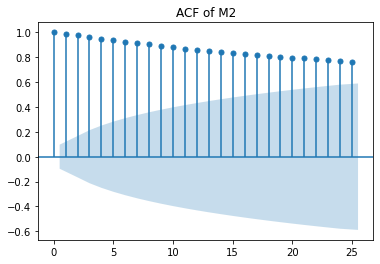

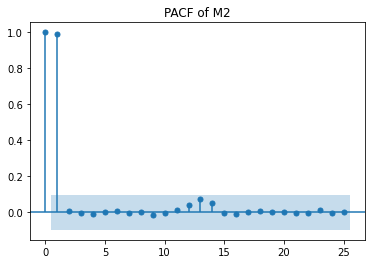

In [109]:
## Now let's analyze M2's ACF and PACF

sm.graphics.tsa.plot_acf(df["M2 Money Supply"].values.squeeze(), lags=25, title='ACF of M2')
sm.graphics.tsa.plot_pacf(df["M2 Money Supply"].values.squeeze(), lags=25, title='PACF of M2')
plt.show()

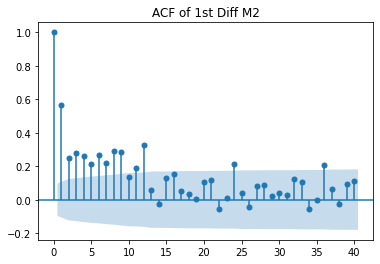

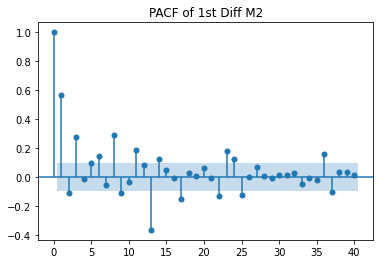

In [110]:
## They look identical to housing's! Let's find the first difference to see if that makes it stationary.

D_M2 = df["M2 Money Supply"].diff()
sm.graphics.tsa.plot_acf(D_M2.values.squeeze(), lags=40, title='ACF of 1st Diff M2', missing= "conservative")
sm.graphics.tsa.plot_pacf(D_M2[1:].values.squeeze(), lags=40, title='PACF of 1st Diff M2')
plt.show()

In [111]:
## These are both stationary as time goes on, with only two really significant lags. 
## Now I want to try a standard AR(2) model with no seasonality, then I'll record the info. criterion
## I will also obtain residuals and fitted values. Another consolidation of the data:
D_housing.rename("D.Housing", inplace=True)
D_M2.rename("D.M2", inplace=True)
my_df = pd.concat([my_df, D_housing, D_M2], axis=1)

In [112]:
## My first model (model_1H) will be an AR(2), then I will analyze residuals and see if there is room for more.
## I will likely try several different models then record their info. criterion to find the best model.
## model_1H is for the first difference of Housing Price Index.
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_model import ARIMA as ARIMA

#### ~~~ This one is muuuch better! ~~~ ####

from statsmodels.tsa.statespace.sarimax import SARIMAX as smax

model_1H = smax(my_df['Housing Price Index (USA)'], order=(2,1,0))
result_1H = model_1H.fit()
print(result_1H.summary())

                                   SARIMAX Results                                   
Dep. Variable:     Housing Price Index (USA)   No. Observations:                  411
Model:                      SARIMAX(2, 1, 0)   Log Likelihood                -143.309
Date:                       Mon, 28 Jun 2021   AIC                            292.617
Time:                               16:11:21   BIC                            304.666
Sample:                           01-01-1987   HQIC                           297.384
                                - 03-01-2021                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5064      0.030     50.419      0.000       1.448       1.565
ar.L2         -0.6174      0.033    -18.602      0.000      -0.682      -0.

In [113]:
### From the Ljung-Box test, we can see that the residuals are white noise stationary (p-value = 0.42)
### The null hypothesis of this test is that the data series is I.I.D. white noise stationary,
### meaning independently and identically distributed stochastic process (white noise). Given a p-value of 0.42,
### we do not reject this null-hypothesis even at the 0.10 level (highly statistically insignificant Q-score)

#### Furthermore, we can see that both of our AR lag terms are statistically significant being less than 0.001. 
#### I will record the BIC to compare to other models that have D.Housing as the endogenous variable.

In [114]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
pred_1H = []
pred_1H = result_1H.get_forecast(steps=16).predicted_mean
print(pred_1H)

2021-04-01    248.964246
2021-05-01    254.074600
2021-06-01    258.496423
2021-07-01    262.002022
2021-08-01    264.552576
2021-09-01    266.230187
2021-10-01    267.182503
2021-11-01    267.581236
2021-12-01    267.593892
2022-01-01    267.366770
2022-02-01    267.016830
2022-03-01    266.629926
2022-04-01    266.263171
2022-05-01    265.949591
2022-06-01    265.703669
2022-07-01    265.526835
Freq: MS, Name: predicted_mean, dtype: float64


In [115]:
housing_predictions1 = pd.DataFrame(pred_1H)
columns = ["House Prediction AR(2)"]
housing_predictions1.columns = columns
test_df = pd.concat([my_df, housing_predictions1], axis=1)


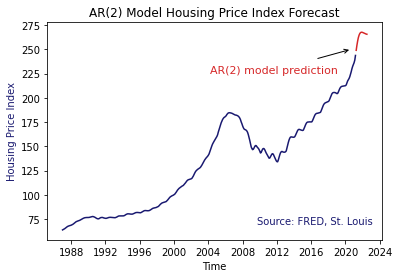

In [116]:


fig, ax = plt.subplots()
ax.plot(test_df.index, test_df["Housing Price Index (USA)"], color='midnightblue')
ax.set_ylabel("Housing Price Index", color='midnightblue')
ax.plot(test_df.index, test_df["House Prediction AR(2)"], color='tab:red')
ax.set_xlabel("Time")
ax.text(12500, 225, "AR(2) model prediction", fontsize=11, color="tab:red")
ax.set_title("AR(2) Model Housing Price Index Forecast")
ax.text(14500, 70, "Source: FRED, St. Louis", fontsize=10, color="midnightblue")
ax.annotate("", xy=(17000, 240), xytext=(18500, 250),
            arrowprops=dict(arrowstyle="<-"))
plt.savefig('/Users/floyd/Projects1/PyplotAndStuff/ar2housingmodel.pdf')  
plt.show()


In [117]:
## Now we should consider either M2, Mortgage rates, or both in a VAR. I'll go ahead and load/prepare the mortgage
## rate data for analysis. I had to make the weekly data monthly, and add in a value for a missing one. I manually 
## entered 9.37% from the data source.

rate = pd.read_csv('/Users/floyd/Projects1/PyplotAndStuff/MORTGAGE30US.csv', 
                 delimiter = ',', 
                 parse_dates = ["DATE"], 
                 index_col = 'DATE')
rate2 = rate.resample('MS').ffill()
rate2.at['1987-01-01'] = 9.37

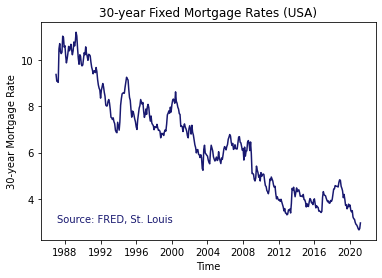

In [118]:
## Now to plot it so we get an indication as to how rates have behaved over time:

fig, ax = plt.subplots()
ax.plot(rate2.index, rate2["MORTGAGE30US"], color='midnightblue')
ax.set_ylabel("30-year Mortgage Rate")
ax.set_xlabel("Time")
ax.set_title("30-year Fixed Mortgage Rates (USA)")
ax.text(6250, 3, "Source: FRED, St. Louis", fontsize=10, color="midnightblue")
plt.show()

In [119]:
### adding the rates to my_df dataframe for ease of access...

columns2 = ["rate"]
rate2.columns = columns2
my_df = pd.concat([my_df, rate2], axis=1)
my_df = my_df.drop(columns=month_names)
my_df.head()

,M2 Money Supply,Housing Price Index (USA),D.Housing,D.M2,rate
DATE,,,,,
1987-01-01,2.7535,63.735,NaN,NaN,9.37
1987-02-01,2.7352,64.135,0.400,-0.0183,9.08
1987-03-01,2.7480,64.471,0.336,0.0128,9.07
1987-04-01,2.7789,64.977,0.506,0.0309,9.03
1987-05-01,2.7597,65.552,0.575,-0.0192,10.47


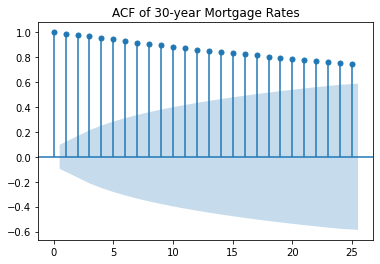

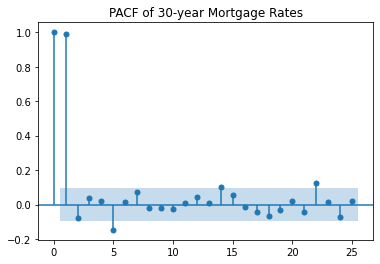

In [120]:
sm.graphics.tsa.plot_acf(my_df['rate'].values.squeeze(),
                         lags=25, title='ACF of 30-year Mortgage Rates')
sm.graphics.tsa.plot_pacf(my_df['rate'].values.squeeze(), 
                          lags=25, title='PACF of 30-year Mortgage Rates')
plt.show()

In [121]:
## Obviously trending over time, so we need to find the first difference. Also going to go ahead and add this to the
## my_df dataframe. Then I'll try both models.

d_rate = pd.DataFrame(my_df['rate'].diff())
column_d = ["D.rate"]
d_rate.columns = column_d
my_df = pd.concat([my_df, d_rate], axis=1)

In [122]:
model_2H = smax(endog = my_df['Housing Price Index (USA)'], exog=my_df['rate'], order=(2,1,0), missing='raise')
result_2H = model_2H.fit()
print(result_2H.summary())

                                   SARIMAX Results                                   
Dep. Variable:     Housing Price Index (USA)   No. Observations:                  411
Model:                      SARIMAX(2, 1, 0)   Log Likelihood                -142.562
Date:                       Mon, 28 Jun 2021   AIC                            293.125
Time:                               16:11:22   BIC                            309.189
Sample:                           01-01-1987   HQIC                           299.480
                                - 03-01-2021                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
rate           0.0523      0.049      1.062      0.288      -0.044       0.149
ar.L1          1.5063      0.030     50.144      0.000       1.447       1.

In [123]:
model_2H = smax(endog = my_df['Housing Price Index (USA)'], exog=my_df['M2 Money Supply'], order=(2,1,0), missing='raise')
result_2H = model_2H.fit()
print(result_2H.summary())

                                   SARIMAX Results                                   
Dep. Variable:     Housing Price Index (USA)   No. Observations:                  411
Model:                      SARIMAX(2, 1, 0)   Log Likelihood                -131.966
Date:                       Mon, 28 Jun 2021   AIC                            271.933
Time:                               16:11:22   BIC                            287.997
Sample:                           01-01-1987   HQIC                           278.288
                                - 03-01-2021                                         
Covariance Type:                         opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
M2 Money Supply     0.8604      0.149      5.789      0.000       0.569       1.152
ar.L1               1.5143      0.031     48.829      0.000 

In [124]:
#-------------------------------|   Analysis   |------------------------------#

### So, it looks like Mortgage rates are not statistically significant at any level. 
### M2 Money Supply is significant any level, the p-value of which is less than 0.001. 
### This model obviously has a better fit when comparing the simple AR(2) I(1) model, where the
### BIC was 304.666 versus the BIC of 287.997 from the model that includes M2. 

### I do not want to conclude that M2 necessarily predicts home prices, but there is an obvious 
### relationship between the two when considering these results. Next step will be producing a chart of the forecast
### and then trying out a VAR model to see if there is a multivariate relationship as both evolve over time.

In [125]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [126]:
### I am going to make a new dataframe that only includes my variables of interest. 
var_df = pd.concat([my_df["D.Housing"], my_df["D.M2"]], axis=1)
var_df = var_df.fillna(method='bfill')

In [127]:
### VAR will perform a Vector Autoregression on my two variables. 
var_model = VAR(var_df)
lags = var_model.select_order(15)
lags.summary()

,AIC,BIC,FPE,HQIC
0,-4.795,-4.775,0.008274,-4.787
1,-6.917,-6.857,0.0009906,-6.893
2,-7.418,-7.318,0.0006002,-7.378
3,-7.570,-7.429,0.0005158,-7.514
4,-7.628,-7.447,0.0004865,-7.557
5,-7.634,-7.412,0.0004840,-7.546
6,-7.656,-7.395,0.0004732,-7.553
7,-7.714,-7.413,0.0004465,-7.595
8,-7.832,-7.490,0.0003969,-7.696
9,-7.922,-7.539,0.0003629,-7.770


In [128]:
### Both BIC and HQIC chose 13 lags, but there does not seem to be a big difference as we increase the 
### number of lags, and I do not want to risk having an unparsimonious model that is overfitted, so
### we will try 4 lags since this is a fairly high BIC without having to have a ridiculous number of lags.

In [149]:
var_results = var_model.fit(maxlags=4, ic="bic")
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 28, Jun, 2021
Time:                     16:18:11
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.50427
Nobs:                     407.000    HQIC:                  -7.61140
Log likelihood:           426.181    FPE:                0.000461262
AIC:                     -7.68156    Det(Omega_mle):     0.000441519
--------------------------------------------------------------------
Results for equation D.Housing
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.015414         0.019436            0.793           0.428
L1.D.Housing         1.493571         0.049716           30.042           0.000
L1.D.M2             -0.587445         0.234711           -2.

In [130]:
from statsmodels.tsa.vector_ar.var_model import VARResults

In [131]:
#-------------------------------|   What now?   |------------------------------#

## So, now let's do some more tests/forecasting steps to see if this is a good model. I want to run a Granger Causality
## Test to see if either time-series is useful in forecasting the other (in this case we think M2 might forecast housing)
## I also want to see if the eigenvalues of this VAR are within the unit circle to make sure the model is stable.
## Last, it would be nice to check out the IRFs associated with both variables. After this, I will decide on a 
## model, and hopefully draw some insight from the impact that money supply has on housing. 


In [150]:
### Stability:
print(var_results.is_stable())

True


In [151]:
## So, the VAR is stable. Yay. So we know that it is covariance stationary, but we can also test
## the residuals to make sure that those are white noise using the Portmanteau test.
## The null hypothesis is that there is no autocorrelaton in the residuals (no time dependent trend)

print(var_results.test_whiteness(nlags = 10))

<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: reject at 5% significance level. Test statistic: 64.789, critical value: 36.415>, p-value: 0.000>


In [ ]:
### Our p-value from this test was less than 0.001, so we reject the null at 5% significance level. 

### Therefore, I won't be using this VAR model to forecast. There is something missing that helps explain how these
### variables evolve over time, and they were left out of this model. Therefore, I will now move on to try out the ARIMA
### model that included M2.